# Импорти и глобални параметри

In [9]:
from dask import dataframe as dd
from datetime import datetime
import matplotlib.pyplot as plt
import pandas_alive

In [10]:
LARGE_FONT = 30
MEDIUM_FONT = 25
SMALL_FONT = 16

TITLE_PADDING = 40
AXIS_PADDING = 30

In [59]:
plt.rc('font', size=MEDIUM_FONT, family='serif')  
plt.rc('axes', titlesize=LARGE_FONT, titlepad=TITLE_PADDING, labelsize=MEDIUM_FONT, labelpad=AXIS_PADDING) 
plt.rc('axes', facecolor='#E6E6E6', grid=True, edgecolor='black', prop_cycle=plt.cycler(color=['#89A3D5']), axisbelow=True)
plt.rc('xtick', labelsize=SMALL_FONT)
plt.rc('ytick', labelsize=SMALL_FONT) 
plt.rc('grid', color='white', linestyle='solid')
plt.rc('figure', figsize=(25,10), facecolor='#E6E6E6')

In [48]:
plt.rcParams.update(plt.rcParamsDefault)

# Импортиране на файлове

In [12]:
ddf_users = dd.read_csv('..\\data\\raw\\2022_place_canvas_history_users.csv')
ddf_users.head()

,user_id
0,ovTZk4GyTS1mDQnTbV+vDOCu1f+u6w+CkIZ6445vD4XN8a...
1,6NSgFa1CvIPly1VniNhlbrmoN3vgDFbMSKqh+c4TTfrr3d...
2,O5Oityp3Z3owzTuwM9XnMggpLcqKEumsOMKGhRiDTTImWb...
3,tc273UiqS0wKa6VwiOs/iz/t4LyPYrhL2Q347awn11IQQE...
4,OOWsU/HLb4UUkQwclDeXFtsJTOXMlAdNHiRpFA1Qk+SxUr...


In [13]:
ddf_main = dd.read_csv('..\\data\\raw\\2022_place_canvas_history_core.csv')
ddf_main.head()

,timestamp,pixel_color,coordinate
0,0,#7EED56,"42,42"
1,12356,#00A368,"999,999"
2,16311,#3690EA,"44,42"
3,21388,#D4D7D9,"2,2"
4,34094,#3690EA,"23,23"


In [14]:
ddf_date = dd.read_csv('..\\data\\raw\\2022_place_canvas_history_datetime.csv')
ddf_date.head()

,datetime
0,2022-04-01 12:00:00
1,2022-04-01 12:00:00
2,2022-04-01 12:00:00
3,2022-04-01 12:00:00
4,2022-04-01 12:00:00


In [15]:
ddf_pivoted = dd.read_csv('..\\data\\raw\\2022_place_canvas_history_pivoted.csv')
ddf_pivoted.head()

,datetime,#000000,#00A368,#2450A4,#3690EA,#51E9F4,#7EED56,#811E9F,#898D90,#9C6926,...,#BE0039,#FF3881,#00CCC0,#515252,#6D001A,#94B3FF,#DE107F,#E4ABFF,#FFB470,#FFF8B8
0,2022-04-01 12:00:00,0,2,3,2,1,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022-04-01 13:00:00,117511,21775,83172,15056,24328,21971,19421,7081,6169,...,0,0,0,0,0,0,0,0,0,0
2,2022-04-01 14:00:00,198737,33085,115221,20169,38124,30806,26811,12597,9609,...,0,0,0,0,0,0,0,0,0,0
3,2022-04-01 15:00:00,242980,35452,98686,25440,42816,33479,27869,17086,12235,...,0,0,0,0,0,0,0,0,0,0
4,2022-04-01 16:00:00,246588,40658,99270,29857,49147,37166,32077,20787,11657,...,0,0,0,0,0,0,0,0,0,0


# Работа с таблицата за потребители

In [16]:
all_users = ddf_users.user_id.value_counts().compute().reset_index(name='num_placed_pixels')

### Стълбовидна диаграма за 20-те най-активни потребители

In [17]:
most_active_users = all_users.head(20).set_index('index')
most_active_users.head()

,num_placed_pixels
index,
kgZoJz//JpfXgowLxOhcQlFYOCm8m6upa6Rpltcc63K6Cz0vEWJF/RYmlsaXsIQEbXrwz+Il3BkD8XZVx7YMLQ==,795
JMlte6XKe+nnFvxcjT0hHDYYNgiDXZVOkhr6KT60EtJAGaezxc4e/eah6JzTReWNdTH4fLueQ20A4drmfqbqsw==,781
LNbGhj45pAeCvBYQF1dPvwx1zVfVTy8AdRxTSHi0pR9YeabE3sAd3Rz1MbLFT5k14j0+grrVgqYO1/6BA/jBfQ==,777
8USqGo14WuZQLG7PSAwqfFwICkU0G4VyHZTuV8D1QSbQHE5GFdC2mIK/pMEC/qF1FQH912SDim3ptEFkYPrYMQ==,767
K54RRTUCFuOU55RzSTkjo/ftbJqVi9miyt52YV6NlENRfUyJTPJKBC47N/s2eh4iNdAKMKxa3gvL2XFqCc9AqQ==,767


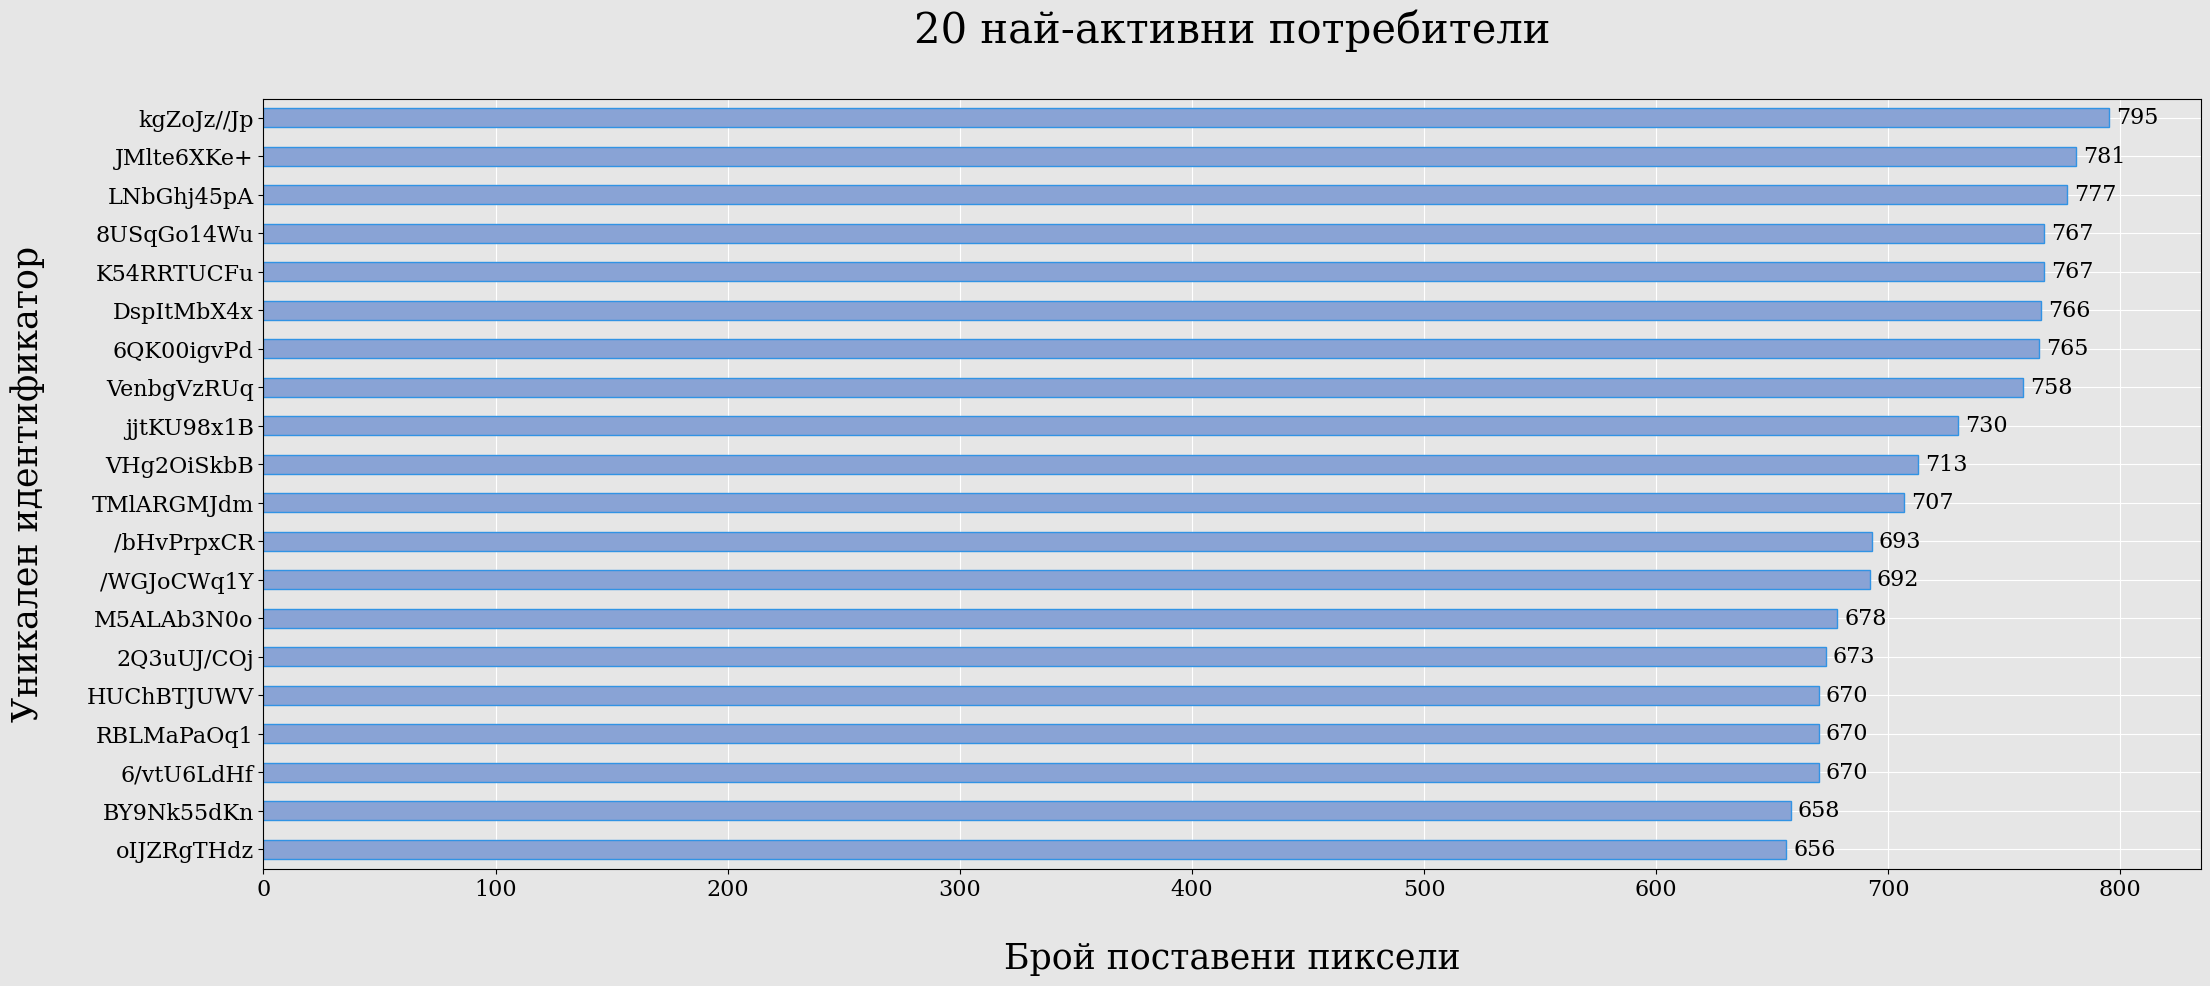

In [60]:
plot = most_active_users.plot(kind='barh', edgecolor='#3193E4')
plot.set_title('20 най-активни потребители')
plot.set_xlabel('Брой поставени пиксели')
plot.set_ylabel('Уникален идентификатор')

y_tick_labels = []
for label in plot.get_yticklabels():
    y_tick_labels.append(label.get_text()[0:10])

plot.set_yticklabels(y_tick_labels)

bar_labels = plot.containers[0]
plot.axes.bar_label(bar_labels, padding=5, fontsize=16)

plot.set_xscale('linear')
plot.invert_yaxis()

plot.get_legend().remove()

### Разпръсната диаграма, представяща броят потребители според броят на поставените им пиксели

In [19]:
num_active_users = all_users.num_placed_pixels.value_counts().reset_index(name='users')
num_active_users.head()

,index,users
0,1,2340498
1,2,1175052
2,3,768335
3,4,572021
4,5,460215


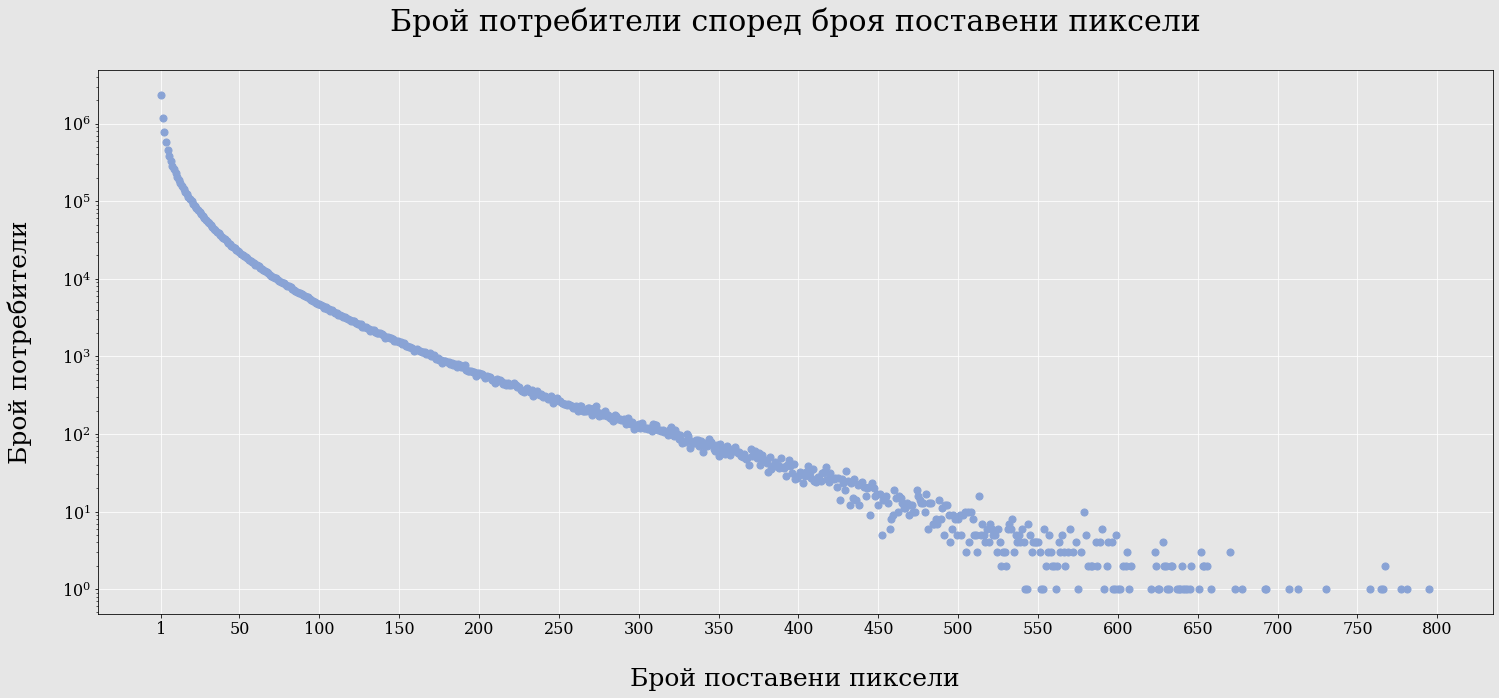

In [38]:
plot = num_active_users.plot(x=0, y=1, kind='scatter', zorder=3, s=50)

plot.set_title('Брой потребители според броя поставени пиксели')
plot.set_xlabel('Брой поставени пиксели')
plot.set_ylabel('Брой потребители')

plot.set_xscale('linear')
plot.set_yscale('log')

plot.set_xticks([1,50,100,150,200,250,300,350,400,450,500,550,600,650,700,750,800])

# Работа с основната информация

## Работа с информация за цветовете

### Диаграма, представяща броят поставени пиксели от всеки цвят

In [21]:
most_used_colors = ddf_main.pixel_color.value_counts().compute()
most_used_colors.head()

#000000    33707371
#FFFFFF    32251013
#FF4500    14411389
#2450A4     9989854
#FFD635     8519392
Name: pixel_color, dtype: int64

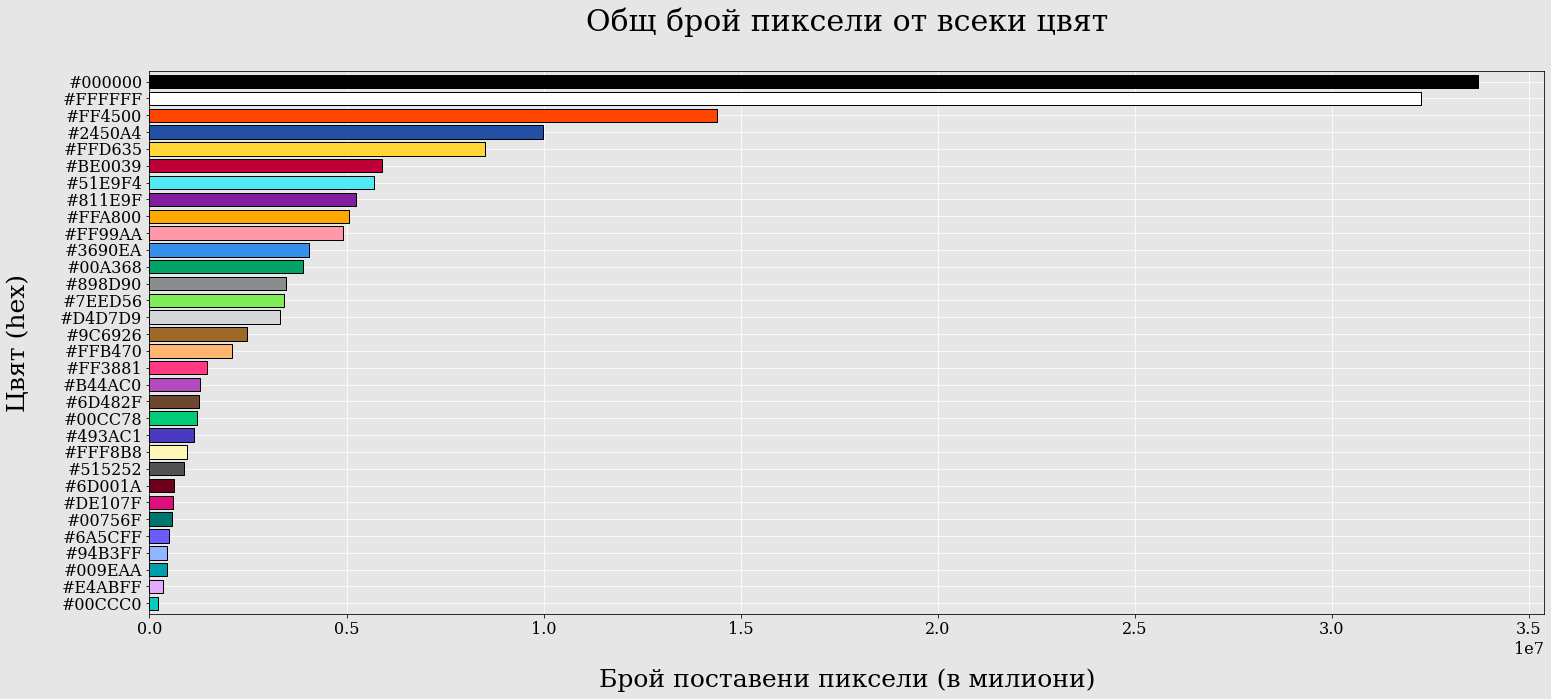

In [39]:
color_bars = []
for color_num in most_used_colors.iteritems():
    color_bars.append(color_num[0])

plot = most_used_colors.plot(kind='barh', color=color_bars, edgecolor='black', zorder=3, width=0.8)

plot.set_title('Общ брой пиксели от всеки цвят')
plot.set_xlabel('Брой поставени пиксели (в милиони)')
plot.set_ylabel('Цвят (hex)')

plot.set_yticklabels(color_bars)
    
plot.set_xscale('linear')
plot.invert_yaxis()

## Работа с информацията за координатите

In [23]:
active_spots = ddf_main.coordinate.value_counts().compute()

### Диаграма, преставяща 20-те най-често променяни точки

In [24]:
top_active_spots = active_spots.head(20)
top_active_spots.head()

0,0        98807
359,564    69198
349,564    55230
859,766    52261
860,766    51485
Name: coordinate, dtype: int64

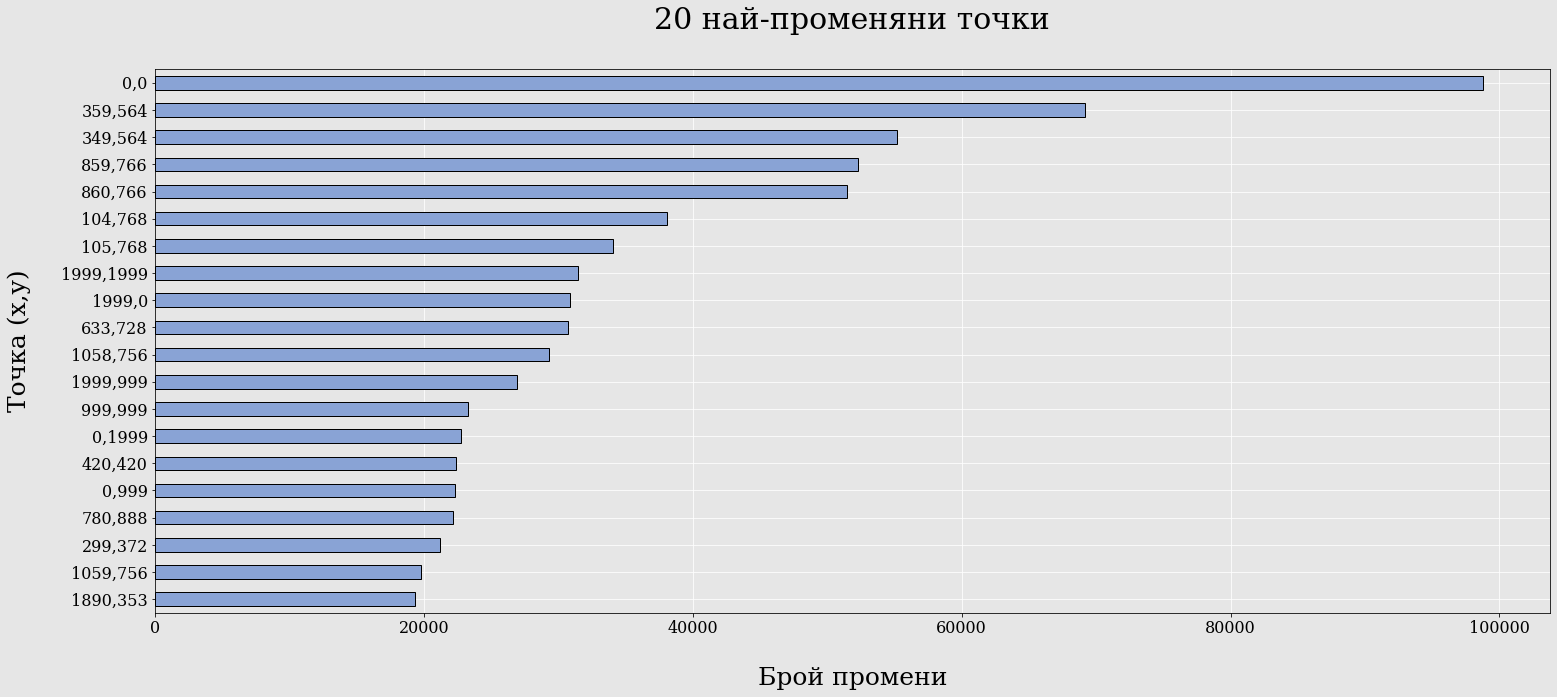

In [40]:
plot = top_active_spots.plot(kind='barh', zorder=3,  edgecolor='#3193E4')

plot.set_title('20 най-променяни точки')
plot.set_xlabel('Брой промени')
plot.set_ylabel('Точка (x,y)')

plot.set_xscale('linear')

plot.invert_yaxis()

## Работа с информацията за времето

In [26]:
date_format = '%H:%M %d-%m-%Y'

### Анимирана графика, показваща броя поставени пиксели за всеки час

In [27]:
ddf_date['datetime'] = dd.to_datetime(ddf_date['datetime'])
ddf_date.dtypes

datetime    datetime64[ns]
dtype: object

In [28]:
ddf_date = ddf_date.datetime.value_counts('datetime').compute()
ddf_date.head()

2022-04-04 21:00:00    5901646
2022-04-04 22:00:00    5640455
2022-04-04 20:00:00    4904479
2022-04-04 19:00:00    4567933
2022-04-03 21:00:00    4480088
Name: datetime, dtype: int64

In [29]:
ddf_date = ddf_date.reset_index(name='num_placed_pixels').sort_values('index').set_index('index')
ddf_date.head()

,num_placed_pixels
index,
2022-04-01 12:00:00,19
2022-04-01 13:00:00,548836
2022-04-01 14:00:00,867847
2022-04-01 15:00:00,996924
2022-04-01 16:00:00,1070919


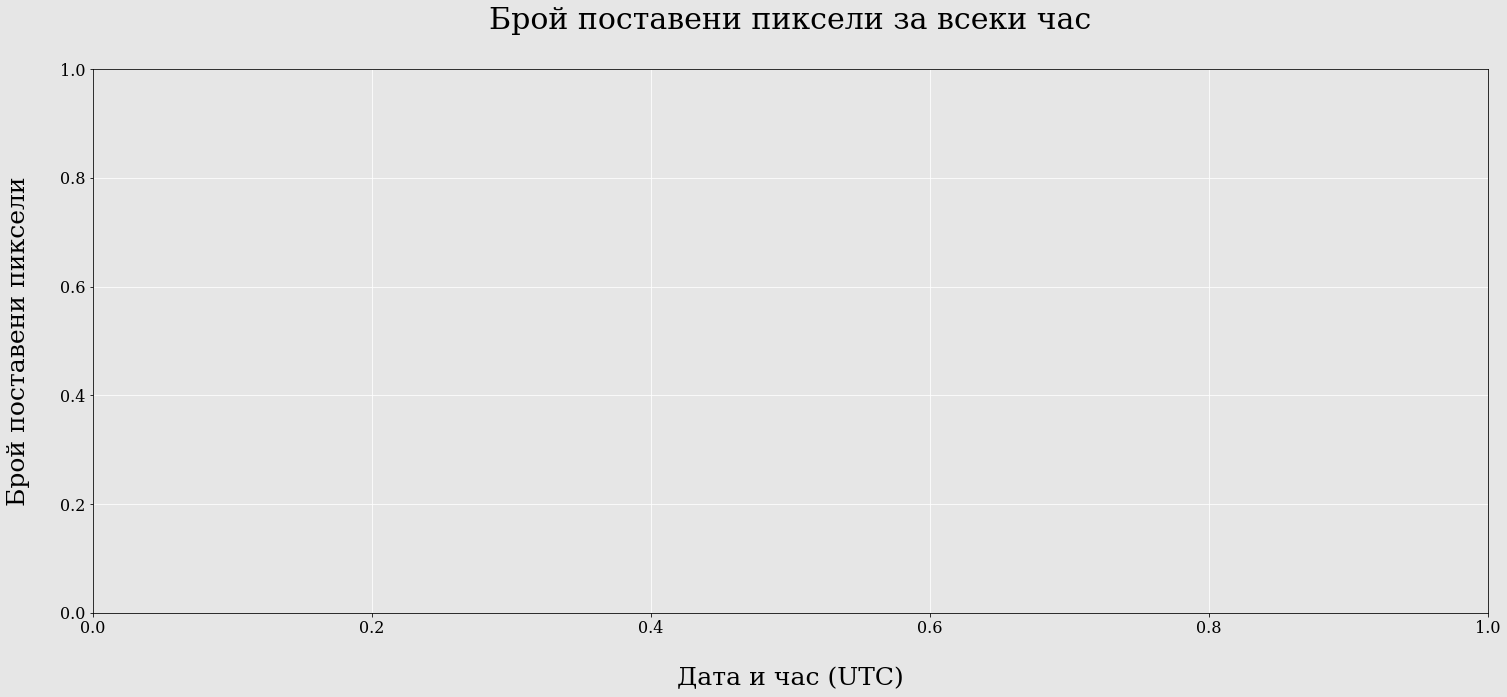

In [41]:
fig = plt.figure()
ax = plt.axes()

ax.set_title('Брой поставени пиксели за всеки час')
ax.set_xlabel('Дата и час (UTC)')
ax.set_ylabel('Брой поставени пиксели')

ax.set_yscale('linear')

ax.get_yaxis().get_major_formatter().set_scientific(False)

In [43]:
now = datetime.now().strftime("%d%H%M")

ddf_date.plot_animated(filename=f'output/activity-{now}.gif', 
    fig=fig, 
    add_legend=False, 
    kind='line', 
    figsize=(25,10),
    period_fmt=date_format,
    period_label=False,
    tick_label_size=SMALL_FONT,
    label_events={    
        '  Първи ден': datetime.strptime('00:00 01-04-2022', date_format),
        '  Втори ден': datetime.strptime('00:00 02-04-2022', date_format),
        '  Трети ден': datetime.strptime('00:00 03-04-2022', date_format),
        '  Четвърти ден': datetime.strptime('00:00 04-04-2022', date_format)
    },
    fill_under_line_color='#89A3D5',
    antialiased=True
    )

Generating LineChart, plotting ['num_placed_pixels']


LineChart(df=                     num_placed_pixels
index                                 
2022-04-01 12:00:00               19.0
2022-04-01 12:12:00           109782.4
2022-04-01 12:24:00           219545.8
2022-04-01 12:36:00           329309.2
2022-04-01 12:48:00           439072.6
...                                ...
2022-04-04 23:12:00          2509747.8
2022-04-04 23:24:00          1962269.6
2022-04-04 23:36:00          1414791.4
2022-04-04 23:48:00           867313.2
2022-04-05 00:00:00           319835.0

[421 rows x 1 columns], interpolate_period=True, steps_per_period=5, period_length=500, period_fmt='%H:%M %d-%m-%Y', figsize=(25, 10), title=None, fig=<Figure size 1800x720 with 1 Axes>, cmap='dark24', tick_label_size=16, period_label=False, period_summary_func=None, fixed_max=False, dpi=144, writer=None, enable_progress_bar=False, kwargs={'antialiased': True}, line_width=2, label_events={'  Първи ден': datetime.datetime(2022, 4, 1, 0, 0), '  Втори ден': datetime.datetime(20

### Анимирана графика, показваща броя и вида поставевни цветове за всеки час

In [32]:
ddf_pivoted['datetime'] = dd.to_datetime(ddf_pivoted['datetime'])
ddf_pivoted = ddf_pivoted.set_index('datetime')

In [33]:
ddf_pivoted = ddf_pivoted.compute()
type(ddf_pivoted)

pandas.core.frame.DataFrame

Text(0.5, 0, 'Брой пиксели')

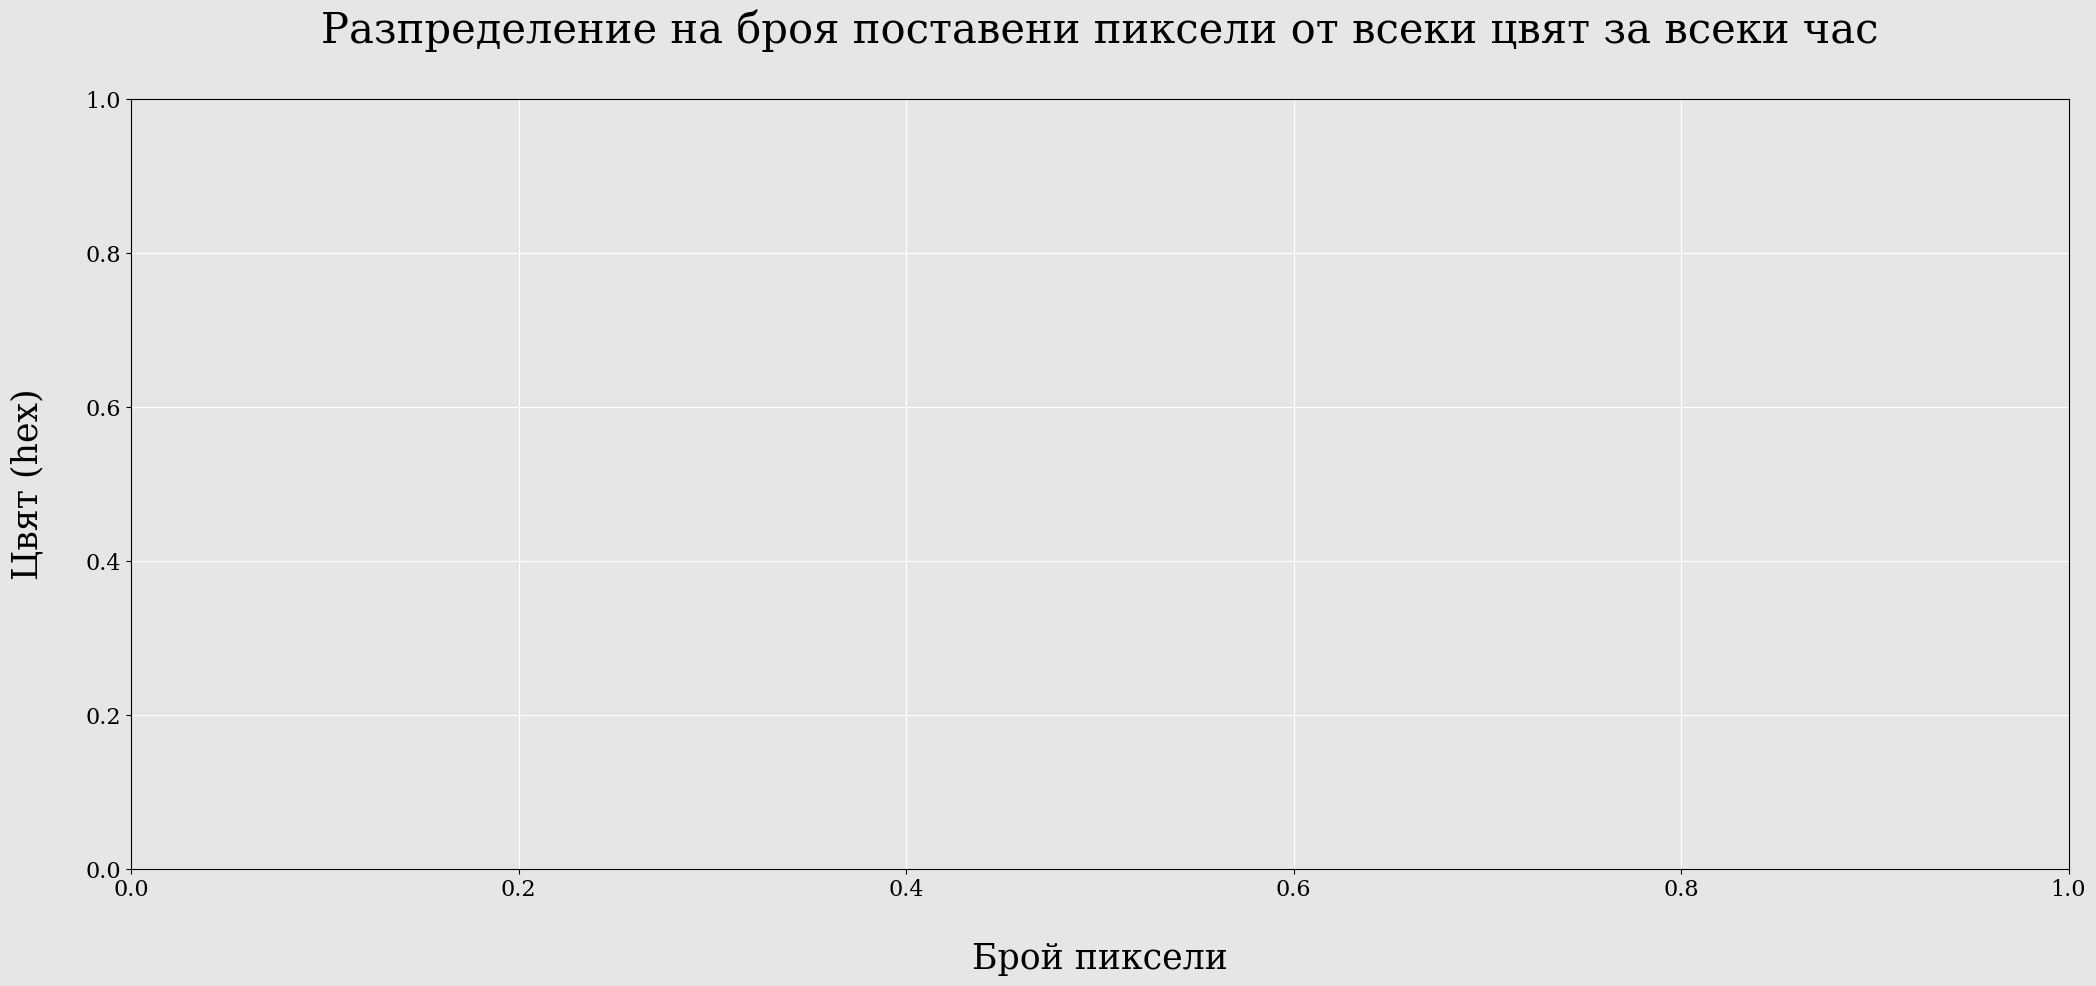

In [55]:
fig = plt.figure()
ax = plt.axes()

ax.set_title('Разпределение на броя поставени пиксели от всеки цвят за всеки час')
ax.set_ylabel('Цвят (hex)')
ax.set_xlabel('Брой пиксели')

In [56]:
now = datetime.now().strftime("%d%H%M")

ddf_pivoted.plot_animated(filename=f'output/colors-{now}.gif',    
    period_length=700,
    bar_label_size=14,
    add_legend=False, 
    figsize=(25,10),
    fig=fig,
    period_fmt=date_format,
    fixed_order=color_bars,
    period_label=True,
    tick_label_size=14,
    cmap=color_bars,
    )

Generating BarChartRace, plotting ['#000000', '#FFFFFF', '#FF4500', '#2450A4', '#FFD635', '#BE0039', '#51E9F4', '#811E9F', '#FFA800', '#FF99AA', '#3690EA', '#00A368', '#898D90', '#7EED56', '#D4D7D9', '#9C6926', '#FFB470', '#FF3881', '#B44AC0', '#6D482F', '#00CC78', '#493AC1', '#FFF8B8', '#515252', '#6D001A', '#DE107F', '#00756F', '#6A5CFF', '#94B3FF', '#009EAA', '#E4ABFF', '#00CCC0']


c:\Users\Denis\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas_alive\charts.py:68: UserWarning: Plotting too many bars may result in undesirable output, use `n_visible=15` to limit number of bars
  warnings.warn(
c:\Users\Denis\AppData\Local\Programs\Python\Python38\lib\site-packages\matplotlib\animation.py:887: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


BarChartRace(df=                     #000000    #FFFFFF  #FF4500  #2450A4  #FFD635  #BE0039  \
datetime                                                                      
2022-04-01 12:00:00      0.0        4.0      1.0      3.0      0.0      0.0   
2022-04-01 12:12:00  23502.2     6444.4  14010.2  16636.8  13389.8      0.0   
2022-04-01 12:24:00  47004.4    12884.8  28019.4  33270.6  26779.6      0.0   
2022-04-01 12:36:00  70506.6    19325.2  42028.6  49904.4  40169.4      0.0   
2022-04-01 12:48:00  94008.8    25765.6  56037.8  66538.2  53559.2      0.0   
...                      ...        ...      ...      ...      ...      ...   
2022-04-04 23:12:00      0.0  2509747.8      0.0      0.0      0.0      0.0   
2022-04-04 23:24:00      0.0  1962269.6      0.0      0.0      0.0      0.0   
2022-04-04 23:36:00      0.0  1414791.4      0.0      0.0      0.0      0.0   
2022-04-04 23:48:00      0.0   867313.2      0.0      0.0      0.0      0.0   
2022-04-05 00:00:00      0.0   31983